In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import math

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import proylib

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/_compat.py:153: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  set_use_pygeos()
/tmp/ipykernel_49683/3575814356.py:5: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


2024-01-04 23:26:27 Configured OSMnx 1.1.2
2024-01-04 23:26:27 HTTP response caching is on


In [2]:
schema = 'hexgrid'
folder = 'hexgrid_9_city_2020'

query = f"SELECT * FROM {schema}.{folder} WHERE \"CVEGEO\" = \'14039\'"

hex_gdf = proylib.gdf_from_query(query)
print(hex_gdf.shape)
hex_gdf.head(2)

(1214, 6)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type
0,89498c95c87ffff,"POLYGON ((-103.29088 20.71405, -103.28966 20.7...",14039,Guadalajara,Guadalajara,urban
1,89498c94e8bffff,"POLYGON ((-103.32868 20.71718, -103.32746 20.7...",14039,Guadalajara,Guadalajara,urban


### Rutas de transporte público

In [3]:
rutas_gdf = gpd.read_file('../data/processed/rutas_tp_gdl.geojson')
print(rutas_gdf.shape)
rutas_gdf.head(2)

(670, 6)


,Tipo_de_se,Clasificac,Clasifica0,layer,path,geometry
0,"T 05, L�pez Mateos",Corredores troncales,Presentadas en grupo de Trabajo,vwCorredores_troncales_mapa_base_mayo_2021,/home/edgaregurrola/Repos/freelance/gdl10k/dat...,"MULTILINESTRING ((661387.867 2270907.072, 6613..."
1,"T 05, L�pez Mateos",Corredores troncales,Presentadas en grupo de Trabajo,vwCorredores_troncales_mapa_base_mayo_2021,/home/edgaregurrola/Repos/freelance/gdl10k/dat...,"MULTILINESTRING ((666791.399 2284313.859, 6667..."


### Ciclovías

In [4]:
ciclista_gdf = gpd.read_file('../data/processed/ciclovias_mibici_gdl.geojson')
print(ciclista_gdf.shape)
ciclista_gdf.head(2)

(5803, 24)


,fid,cat,Nombre_de_,Municipio,Ao__o_de_c,Ao__o_de_r,Tipo_de_di,Tipo_de_ci,vertex_pos,vertex_ind,...,id,name,obcn,location,latitude,longitude,status,layer,path,geometry
0,1.0,1.0,Prolongaci�n Laureles,Zapopan,2019,N/A,Unidireccional,Confinada,0.0,0.0,...,NaN,None,None,None,NaN,NaN,None,ciclovias_vertex,/home/edgaregurrola/Repos/freelance/gdl10k/dat...,POINT (668155.050 2293313.298)
1,1.0,1.0,Prolongaci�n Laureles,Zapopan,2019,N/A,Unidireccional,Confinada,-1.0,1.0,...,NaN,None,None,None,NaN,NaN,None,ciclovias_vertex,/home/edgaregurrola/Repos/freelance/gdl10k/dat...,POINT (668168.262 2293359.411)


### Paradas transporte público

In [5]:
tp_gdf = gpd.read_file('../data/processed/paradas_tp_gdl.geojson')
tp_gdf = tp_gdf.explode()
tp_gdf = tp_gdf.to_crs("EPSG:4326")
print(tp_gdf.shape)
tp_gdf.head(2)

(12441, 11)


,,Disponibil,Disponibli,Disponibi0,Disponibi1,Disponibi2,Vegetaci�n,Clasificac,Rutas_que_,Rutas_adic,Municipio,geometry
0,0,No,No,No,No,No,No,Parada convergente (2 o m�s rutas),"Troncal 13A Solidaridad, Troncal 13B Solidarid...",N/A,El Salto,POINT (-103.26406 20.54483)
1,0,No,No,No,No,No,No,Parada convergente (2 o m�s rutas),"Troncal 19 Perif�rico, C19, C46-V1, C46-V2, C106",N/A,Tonal�,POINT (-103.25837 20.61802)


### Paradas transporte público masivo

In [6]:
tp_masivo_gdf = gpd.read_file('../data/processed/paradas_tp_masivo_gdl.geojson')
print(tp_masivo_gdf.shape)
tp_masivo_gdf.head(2)

(119, 6)


,Nombre_de_,Sistema,Estructura,Estado,L�nea_y_si,geometry
0,San Juan de Ocot�n,BRT (Bus Rapid Transit),Superficie,En proceso,Mi Macro Perif�rico,MULTIPOINT (662315.284 2290788.242)
1,8 de Julio,BRT (Bus Rapid Transit),Superficie,En proceso,Mi Macro Perif�rico,MULTIPOINT (668890.558 2276995.459)


### Nodes, edges

In [7]:
hex_gdf = hex_gdf.set_crs("EPSG:4326")

G,nodes,edges = proylib.graph_from_hippo(hex_gdf, schema='osmnx', 
                    edges_folder='edges_speed', nodes_folder='nodes_elevation')

2024-01-04 23:32:04 Created graph from node/edge GeoDataFrames


## Proximity analysis

### Ciclista

In [8]:
ciclo_osmid = proylib.find_nearest(G, nodes, ciclista_gdf, return_distance= True)

In [9]:
nodes_ciclo = proylib.calculate_distance_nearest_poi(ciclo_osmid, nodes, 
                                                     edges, 'ciclo', 'osmid', wght='time_min')
nodes_ciclo = nodes_ciclo.reset_index()
nodes_ciclo.head(4)

,osmid,index,x,y,street_count,elevation,geometry,dist_ciclo
0,28751344,0,-103.306309,20.711533,3.0,1548.0,POINT (-103.30631 20.71153),76.061362
1,28753224,1,-103.316645,20.700650,3.0,1530.0,POINT (-103.31665 20.70065),91.862351
2,28757751,2,-103.307356,20.708526,3.0,1548.0,POINT (-103.30736 20.70853),81.335542
3,28757777,3,-103.306806,20.710093,4.0,1548.0,POINT (-103.30681 20.71009),78.584617


### Transporte público

In [10]:
tp_osmid = proylib.find_nearest(G, nodes, tp_gdf, return_distance= True)

In [11]:
nodes_tp = proylib.calculate_distance_nearest_poi(tp_osmid, nodes, 
                                                     edges, 'tp', 'osmid', wght='time_min')
nodes_tp = nodes_tp.reset_index()
nodes_tp.head(4)

,osmid,index,x,y,street_count,elevation,geometry,dist_tp
0,28751344,0,-103.306309,20.711533,3.0,1548.0,POINT (-103.30631 20.71153),0.000000
1,28753224,1,-103.316645,20.700650,3.0,1530.0,POINT (-103.31665 20.70065),3.024833
2,28757751,2,-103.307356,20.708526,3.0,1548.0,POINT (-103.30736 20.70853),0.000000
3,28757777,3,-103.306806,20.710093,4.0,1548.0,POINT (-103.30681 20.71009),0.000000


<AxesSubplot: >

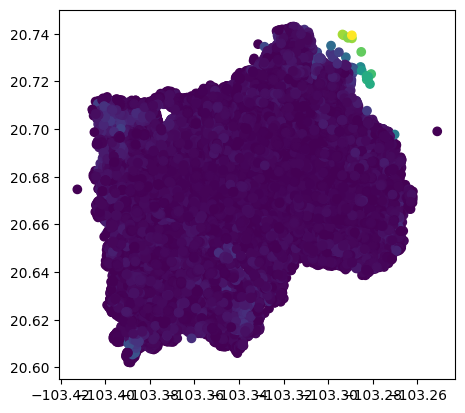

In [13]:
nodes_tp.plot('dist_tp')

### Transporte público masivo

In [15]:
tp_masivo_gdf = tp_masivo_gdf.explode() 

In [16]:
tpm_osmid = proylib.find_nearest(G, nodes, tp_masivo_gdf, return_distance= True)

In [18]:
nodes_tpm = proylib.calculate_distance_nearest_poi(tpm_osmid, nodes, 
                                                     edges, 'tpm', 'osmid', wght='time_min')
nodes_tpm = nodes_tpm.reset_index()
nodes_tpm.head(4)

,osmid,index,x,y,street_count,elevation,geometry,dist_tpm
0,28751344,0,-103.306309,20.711533,3.0,1548.0,POINT (-103.30631 20.71153),76.061362
1,28753224,1,-103.316645,20.700650,3.0,1530.0,POINT (-103.31665 20.70065),91.862351
2,28757751,2,-103.307356,20.708526,3.0,1548.0,POINT (-103.30736 20.70853),81.335542
3,28757777,3,-103.306806,20.710093,4.0,1548.0,POINT (-103.30681 20.71009),78.584617


<AxesSubplot: >

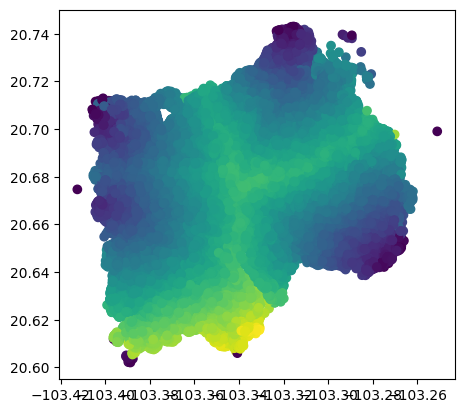

In [19]:
nodes_tpm.plot('dist_tpm')

### Número de rutas

In [36]:
hex_gdf = hex_gdf.to_crs("EPSG:32613")
rutas_hex = rutas_gdf.overlay(hex_gdf, how='intersection')
rutas_hex = rutas_hex.groupby('hex_id_9').count()

In [37]:
rutas_hex = rutas_hex.reset_index()
rutas_hex = rutas_hex[['hex_id_9','city']]
rutas_hex = rutas_hex.rename(columns={'city':'ruta_count'})

## Data to hex

<AxesSubplot: >

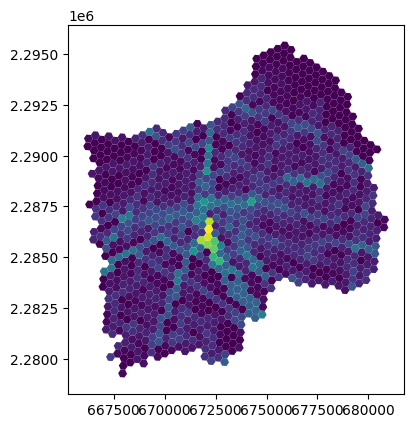

In [38]:
hex_connectivity = hex_gdf.merge(rutas_hex, on='hex_id_9', how='left')
hex_connectivity = hex_connectivity.fillna(0)
hex_connectivity.plot('ruta_count')

In [41]:
hex_connectivity.head(2)

,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,ruta_count
0,89498c95c87ffff,"POLYGON ((677982.641 2291440.466, 678107.875 2...",14039,Guadalajara,Guadalajara,urban,0.0
1,89498c94e8bffff,"POLYGON ((674042.522 2291745.980, 674167.759 2...",14039,Guadalajara,Guadalajara,urban,18.0


In [42]:
nodes_ciclo = nodes_ciclo.to_crs("EPSG:32613")
hex_connectivity = proylib.group_by_hex_mean(nodes_ciclo, hex_connectivity, 9, 'dist_ciclo')
hex_connectivity = hex_connectivity.drop(columns=['index','x','y','street_count',
                                                 'elevation','ruta_count_y'])
hex_connectivity = hex_connectivity.rename(columns={'ruta_count_x':'ruta_count'})
print(hex_connectivity.shape)
hex_connectivity.head(2)

(1214, 8)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,ruta_count,dist_ciclo
0,89498c95c87ffff,"POLYGON ((677982.641 2291440.466, 678107.875 2...",14039,Guadalajara,Guadalajara,urban,0.0,93.868405
1,89498c94e8bffff,"POLYGON ((674042.522 2291745.980, 674167.759 2...",14039,Guadalajara,Guadalajara,urban,18.0,65.031282


<AxesSubplot: >

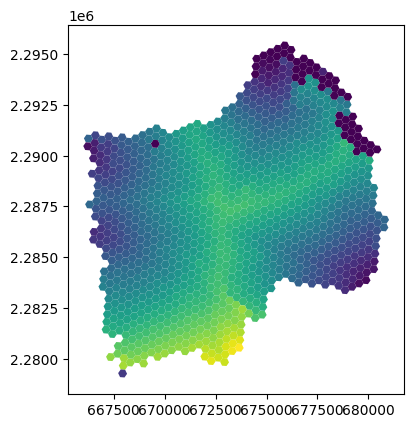

In [43]:
hex_connectivity.plot('dist_ciclo')

In [45]:
nodes_tp = nodes_tp.to_crs("EPSG:32613")
hex_connectivity = proylib.group_by_hex_mean(nodes_tp, hex_connectivity, 9, 'dist_tp')
hex_connectivity = hex_connectivity.drop(columns=['index','x','y','street_count',
                                                 'elevation','ruta_count_y','dist_ciclo_y'])
hex_connectivity = hex_connectivity.rename(columns={'ruta_count_x':'ruta_count',
                                                   'dist_ciclo_x':'dist_ciclo'})
print(hex_connectivity.shape)
hex_connectivity.head(2)

(1214, 9)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,ruta_count,dist_ciclo,dist_tp
0,89498c95c87ffff,"POLYGON ((677982.641 2291440.466, 678107.875 2...",14039,Guadalajara,Guadalajara,urban,0.0,93.868405,4.606166
1,89498c94e8bffff,"POLYGON ((674042.522 2291745.980, 674167.759 2...",14039,Guadalajara,Guadalajara,urban,18.0,65.031282,1.110908


<AxesSubplot: >

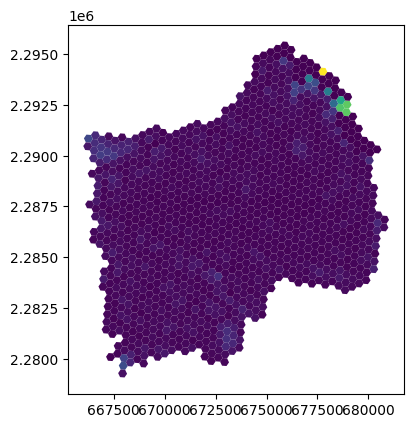

In [46]:
hex_connectivity.plot('dist_tp')

In [48]:
nodes_tpm = nodes_tpm.to_crs("EPSG:32613")
hex_connectivity = proylib.group_by_hex_mean(nodes_tpm, hex_connectivity, 9, 'dist_tpm')
hex_connectivity = hex_connectivity.drop(columns=['index','x','y','street_count',
                                                 'elevation','ruta_count_y','dist_ciclo_y',
                                                 'dist_tp_y'])
hex_connectivity = hex_connectivity.rename(columns={'ruta_count_x':'ruta_count',
                                                   'dist_ciclo_x':'dist_ciclo',
                                                   'dist_tp_x':'dist_tp'})
print(hex_connectivity.shape)
hex_connectivity.head(2)

(1214, 10)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,ruta_count,dist_ciclo,dist_tp,dist_tpm
0,89498c95c87ffff,"POLYGON ((677982.641 2291440.466, 678107.875 2...",14039,Guadalajara,Guadalajara,urban,0.0,93.868405,4.606166,93.868405
1,89498c94e8bffff,"POLYGON ((674042.522 2291745.980, 674167.759 2...",14039,Guadalajara,Guadalajara,urban,18.0,65.031282,1.110908,65.031282


<AxesSubplot: >

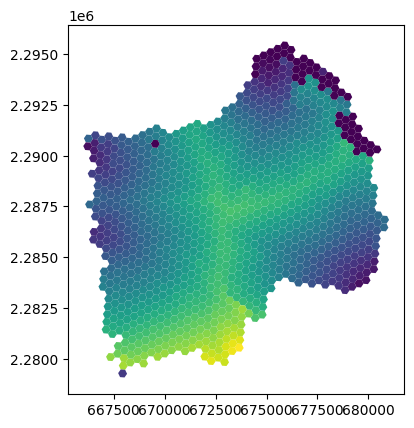

In [50]:
hex_connectivity.plot('dist_tpm')

In [51]:
hex_connectivity.to_file('../data/processed/hex_connectivity.geojson')